# Formula 1 Predictiv Analysis

## Siege der Fahrer

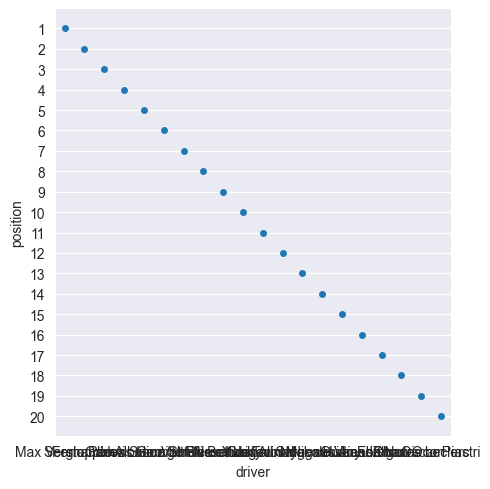

In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import pyergast as pyergast
#print(pyergast.get_race_result(2023,1))
position =pyergast.get_race_result(2023,1)
position.head()
sns.catplot(x=position["driver"], y=position["position"])


In [2]:
position =pyergast.query_driver("max_verstappen")
position.head()
position['season'] = position['season'].astype(int)

data = position[position["season"] >2021]
print(data)

   season round position positionText points wins          driver nationality  \
7    2022    22        1            1    454   15  Max Verstappen       Dutch   
8    2023    22        1            1    575   19  Max Verstappen       Dutch   

  constructorID constructor  
7      red_bull    Red Bull  
8      red_bull    Red Bull  


## Lineare Regression: Position im Jahre 2022
Sind Lineare Regressionsmodelle dazu geeignet?

/var/folders/xx/2vcsfvfd5153jhcrrwmd9q2w0000gn/T/ipykernel_29975/1150547036.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


        surname  position  round
0         Albon        10      1
1        Alonso         3      1
2        Bottas         8      1
3      de Vries        14      1
4         Gasly         9      1
..          ...       ...    ...
435    Sargeant        16     22
436      Stroll        10     22
437     Tsunoda         8     22
438  Verstappen         1     22
439        Zhou        17     22

[440 rows x 3 columns]


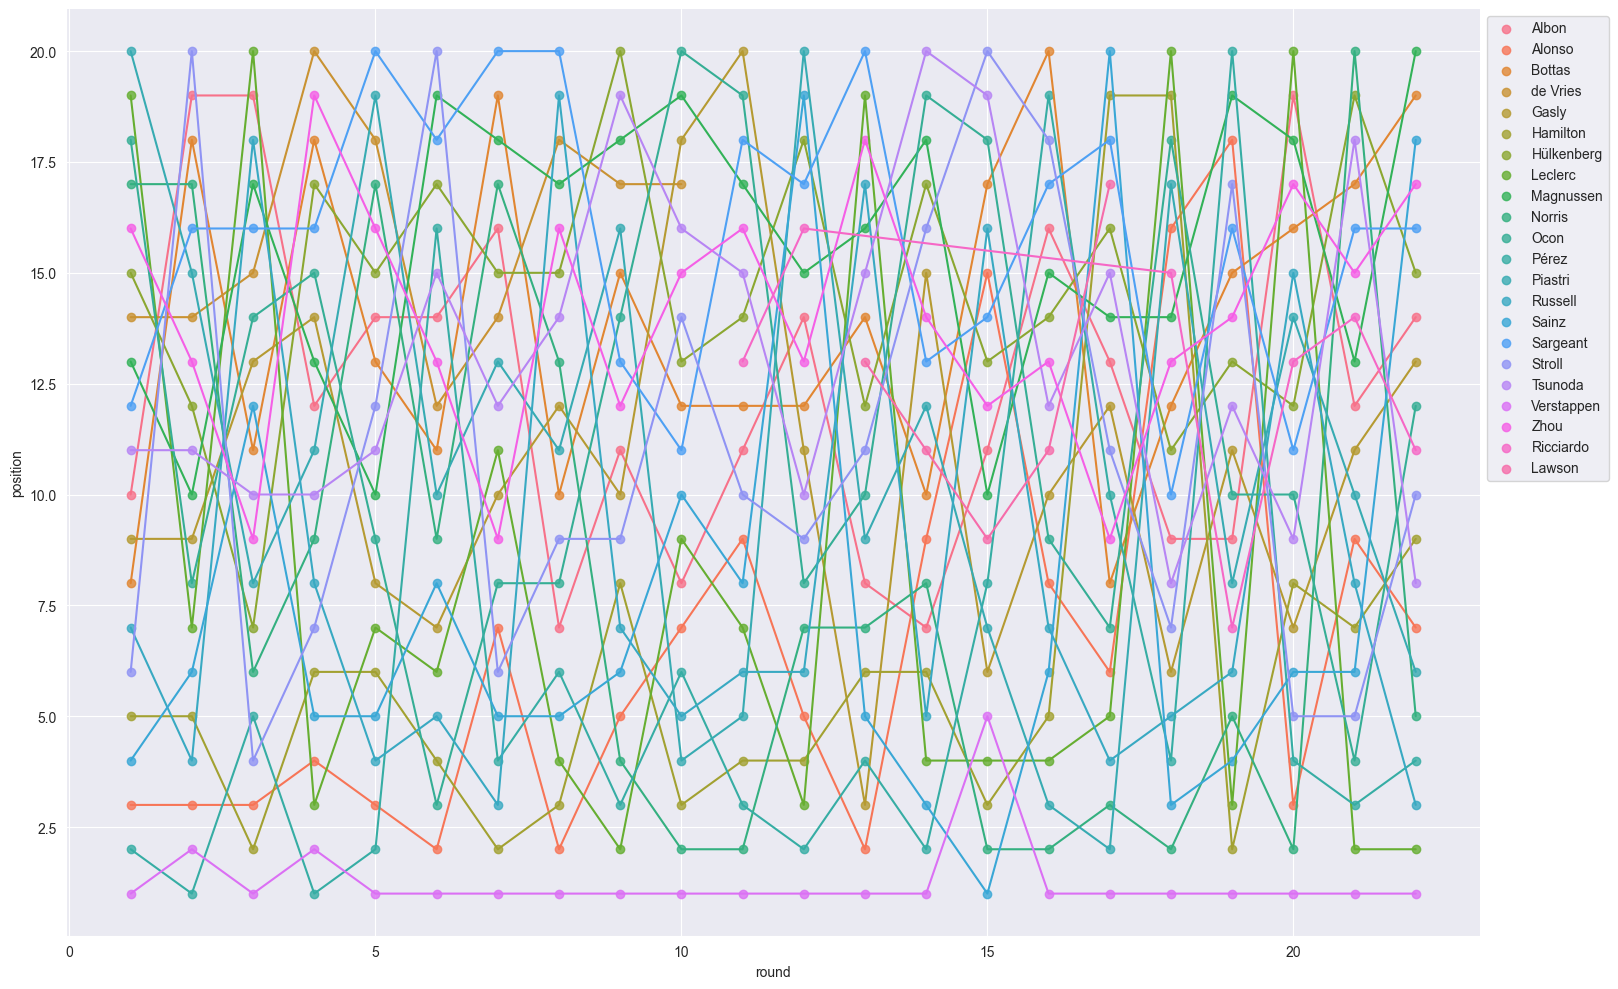

In [3]:
import pandasql as ps
import DatabaseConnection as DatabaseConnection



db_connection = DatabaseConnection.DatabaseConnection()
conn = db_connection.connect()

cur = conn.cursor()

sql= ("SELECT drivers.surname, position,races.round"
      " from results"
      " inner join races on (races.raceid=results.raceid)"
      " inner join drivers on  (results.driverid = drivers.driverid) where races.year=2023")

df = pd.read_sql_query(sql, conn)
print(df)

# Use the 'hue' argument to provide a factor variable
graph= sns.lmplot( x="round", y="position", data=df, fit_reg=False, hue='surname', height=10, aspect=1.5, legend=False)
sns.lineplot(x="round", y="position", data=df, hue='surname', legend=False)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#sns.move_legend(graph, "upper left", bbox_to_anchor=(1, 1))
# Move the legend to an empty part of the plot



plt.show()

Hier sieht man das die Rennergebniss sehr ausgewogen sind. Um es einfach auszudrücken sind die Fahrer meisten sehr gut oder schlecht. Die Gründe dafür können sein:
- Schäden am Rennwagen durch den Verschleiß der Teile, aber auch  Verursacht durch anderer Fahrer.
- Team-Error: Falscher Strategie zu Ruf, Pit Crew Fehler beim Reifenwechsel
- "Showtime-Moment", bei Heimstrecken sind die Fahrer besonders bemüht eine hohe Platzierung zu holen


Im folgenden Sieht man auch nochmal wie diese Anomalien Auswirkungen auf das Lineare  Regressionsmodell haben:

<Axes: title={'center': 'surname = Lawson'}, xlabel='round', ylabel='position'>

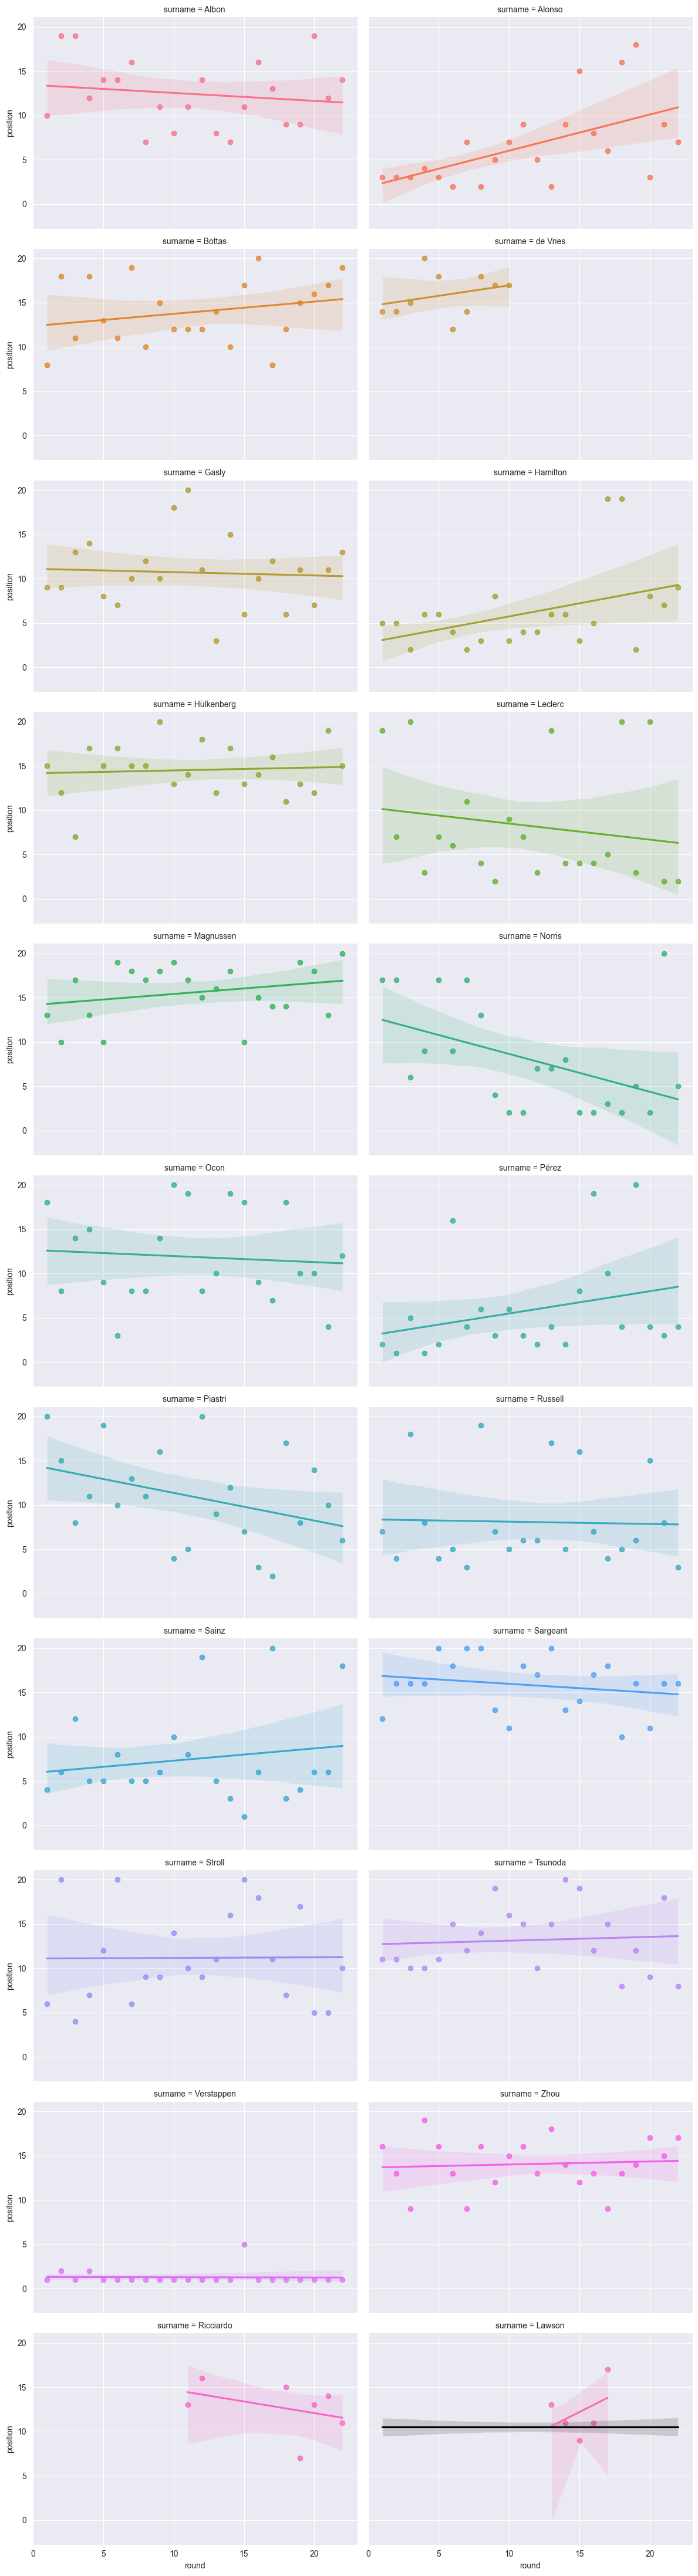

In [4]:
from pandas.plotting import parallel_coordinates



graph = sns.lmplot(x="round", y="position", data=df, hue='surname', col='surname', col_wrap=2, height=4, aspect=1.5)
sns.regplot(x="round", y="position", data=df, scatter=False, color='black')


Diese Anomalien haben als Ursache, dass wir zwar Tendenzen gegenüber der Leistung des Fahreres geben können, aber nicht besonders Aussagekräftig sind beim Vorhersagen einer nächsten Platzierung. 
Wie auch schon zuvor erwähnt ist die Leistung des Fahrers nicht nur von sich selbst abhängig, sondern auch zum sehr großen Teil vom Team.
“We win and lose together.” – Lewis Hamilton

Abseits dieser Anomalien 

Andere Abhängigkeiten :
jahre (allgemein) :platzierung
jahre in formel 1

qualifyingposition:position
qualifying Güte

überholperfomance 
überholmöglichkeiten auf der rennstrecke



position =  constructorstanding + driverstanding+ qualiyingposition + überholperfomance+ jahre + strecke 


Multinomiale Logistische Regressipn




## Multinomiale logistische Regression

In [10]:


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

db_connection = DatabaseConnection.DatabaseConnection()
conn = db_connection.connect()

cur = conn.cursor()

sql = ("""
SELECT results.position,
        drivers.surname,
        constructorstandings.position as constructorPosition,
         driverstandings.position as driverstandingPosition,
         qualifying.position as qualfyingposition,
         races.raceId

FROM results
         inner join races on (results.raceid = races.raceid)
         inner join drivers on (results.driverid = drivers.driverid)
         inner join constructorstandings on (results.constructorId = constructorstandings.constructorId) AND (races.raceId = constructorstandings.raceId)
         inner join driverstandings on (results.driverid = driverstandings.driverid) AND (races.raceId = driverstandings.raceId)
         inner join qualifying on (results.driverid = qualifying.driverid) AND races.raceId = qualifying.raceId
         inner join circuits on (races.circuitid = circuits.circuitid)
            where races.year <= 2022 AND drivers.driverid = 802
""")

df = pd.read_sql_query(sql, conn)
#df.head()

# Check data types and unique values of 'position' column
print(df['position'].dtype)
print(df['position'].unique())

# Assuming 'position' is numeric, convert it to categorical
# For example, if 'position' ranges from 1 to n, you can convert it to categorical
# df['position'] = pd.Categorical(df['position'])

# Define features and target
features = df[['constructorposition', 'driverstandingposition', 'qualfyingposition', 'raceid']]

target = df['position'] 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=42
)

# Create the multinomial logistic regression model
model = LogisticRegression(multi_class="multinomial", solver="saga", max_iter=10000)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions_df)
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred, zero_division=1))


/var/folders/xx/2vcsfvfd5153jhcrrwmd9q2w0000gn/T/ipykernel_29975/480226525.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


int64
[13  7 17 18 11 15  8 16  4 12  9 10  6 19  1  2  5  3 20]
     Actual  Predicted
135       1          1
115       6          1
131       1          1
55        2          2
95        3          1
29        5          2
156       1          1
51       19          2
101       2          1
145       1          1
19       10         19
85        3          1
15        4         19
66        3          1
24       18          9
30        3          2
132      18          1
105       2          1
151       2          1
16        9         19
75        5          2
18       16         19
12        8         19
9         4         19
31       11          1
154       1          1
98        6          1
56        4          2
134       2          1
159       1          1
139       2          1
78        1          1
60        6          2
84        4          1
2        17          9
94        8          2
45        5          2
42       18          2
69       15          2
152       1    